# DS Growth Case Study

## Context: 
A user is looking for loans on Google and enters a search query. Depending on how related the search query is to FFN business, we choose to bid for the query with the goal of maximizing the user impressions using Google Adwords (Google actually showing the ad to the user when they execute the search). This would lead to more clicks on ads, and potentially more signups, activations, and revenue. Here activation is defined as a user successfully contacted by FFN call center.

## Questions:

1.	Using the dataset attached ‘clicks-activation_v2.csv’, build a model to predict the probability of activation per click.

2.	Please create a presentation using the following guidelines:
  -	Describe the workflow steps (explicitly setting up the optimization problem and choice of objective function) and your hypothesis.
  -	Evaluate the performance of the model (pre-production)?
  -	What are some of the shortcomings of this approach?
  -	What are some other features you might need to come up with a better model?

3.	What does the engineering architecture to productionize one of the solutions looks like? What trade-offs would you use to productionize promising algorithms faster?

4.	Discuss how will you analyze the business performance of the algorithm once in production using metrics such as marketing ROI etc.?

Each of the four parts above carry equal weightage in evaluation. We don’t think you need to spend more than 3 hours on the overall exercise (please feel free to take more time if you want). If you have questions please contact: azajic@freedomfinancialnetwork.com

## Data Dictionary:

1.	created_date - date on which the click was recorded
2.	location_in_query - city name that appeared in search query
3.	platform - platform such as web/mobile
4.	campaign_state - US state where the ad campaign was run
5.	in_city - whether the ad campaign was run in a city or not
6.	is_prime - whether the word fico prime appeared in the search query
7.	is_hardship - whether the word hardship appeared in the search query
8.	category_debt_type - type of debt solution that appeared in the search query
9.	[TARGET] is_activated – whether the user talked to FFN call center or not


# Loading required modules

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Loading the data
Let's load the data file as Pandas DateFrame:

In [3]:
#loading the data
clicks = pd.read_csv('drive/My Drive/ffn/data/clicks-activation_v2.csv')

#creating a new column for time as integer
clicks['time_index'] = pd.to_datetime(clicks['created_date']).astype(int)

#printing data types for each columns
print(clicks.dtypes, '\n')

#printing info summary
print(clicks.info(), '\n')

#printing first few rows
clicks.head()

created_date          object
location_in_query     object
platform              object
campaign_state        object
in_city                int64
is_prime               int64
is_hardship            int64
is_activated            bool
category_debt_type    object
time_index             int64
dtype: object 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94194 entries, 0 to 94193
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   created_date        94194 non-null  object
 1   location_in_query   94179 non-null  object
 2   platform            94194 non-null  object
 3   campaign_state      94188 non-null  object
 4   in_city             94194 non-null  int64 
 5   is_prime            94194 non-null  int64 
 6   is_hardship         94194 non-null  int64 
 7   is_activated        94194 non-null  bool  
 8   category_debt_type  84335 non-null  object
 9   time_index          94194 non-null  int64 
dtypes: b

,created_date,location_in_query,platform,campaign_state,in_city,is_prime,is_hardship,is_activated,category_debt_type,time_index
0,12/27/2017,san antonio,mobile web,tx,1,0,0,True,debt_settlement,1514332800000000000
1,1/10/2018,honolulu,mobile web,hi,0,0,0,False,debt_settlement,1515542400000000000
2,12/15/2017,atlanta,desktop web,ga,1,0,0,True,debt_settlement,1513296000000000000
3,1/6/2018,honolulu,mobile web,hi,0,0,0,False,debt_settlement,1515196800000000000
4,12/20/2017,South Beachmi,mobile web,fl,0,0,0,False,cash_loan,1513728000000000000


In [4]:
clicks['is_activated'] = np.where(clicks['is_activated']==True, 0, 1)

In [5]:
clicks.is_activated.value_counts()

1    87407
0     6787
Name: is_activated, dtype: int64

As shown above there are missing values in different columns. We can take a closer look at the statistics  using the below command.

In [6]:
print(clicks.isnull().sum())

created_date             0
location_in_query       15
platform                 0
campaign_state           6
in_city                  0
is_prime                 0
is_hardship              0
is_activated             0
category_debt_type    9859
time_index               0
dtype: int64


# Incorporating Date and Time
I use time/date as two main features: 1) as a categorical variable 2) as a continuous normalized number

In [7]:
scaler = MinMaxScaler()
clicks[['time_index']] = scaler.fit_transform(clicks[['time_index']])


# Imputation
There are missing values in three categorical columns that should be imputed: `location_in_query`, `campaign_state`, and `category_debt_type`.

In [8]:
states = ['al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 
          'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn',
          'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny', 'nc', 'nd', 'oh',
          'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va', 'wa', 
          'wv', 'wi', 'wy']

# also imputing states where the value is a number
clicks.loc[~clicks['campaign_state'].isin(states),'campaign_state'] = np.nan

#imputing campaign_state with the most frequent state
clicks['campaign_state'].fillna(clicks['campaign_state'].mode()[0], inplace = True)

#imputing location_in_query with the unknown_location
clicks['location_in_query'].fillna('unknown_location', inplace = True)

#imputing category_debt_type with the most frequent value
clicks['category_debt_type'].fillna(clicks['category_debt_type'].mode()[0], inplace = True)

print(clicks.isnull().sum())

created_date          0
location_in_query     0
platform              0
campaign_state        0
in_city               0
is_prime              0
is_hardship           0
is_activated          0
category_debt_type    0
time_index            0
dtype: int64


# Balance the data
As the training data is imbalanced, we need to adjust number of positive vs negaive labels. 

In [9]:
from sklearn.utils import resample

data = clicks.copy()

#check the length of each class
print('oringal data class size:\n',data.is_activated.value_counts(), '\n')

#creating subsets
data_not_activated = data[np.array(data.is_activated) == 0]
data_activated = data[np.array(data.is_activated) == 1]

#upsampling of the minorty class
n_samples = len(data_activated)

#downsampling of the minorty class
#n_samples = len(data_not_activated)

data_not_activated_resampled = resample(data_not_activated, n_samples = n_samples, random_state = 0)
data_activated_resampled = resample(data_activated, n_samples = n_samples, random_state = 0)

#merged data back together
data_resampled = pd.concat([data_not_activated_resampled, data_activated_resampled])

#shuffle the data
data_resampled = data_resampled.sample(frac = 1) 

#check the final stats
print('resampled data class size:\n', data_resampled.is_activated.value_counts())

oringal data class size:
 1    87407
0     6787
Name: is_activated, dtype: int64 

resampled data class size:
 1    87407
0    87407
Name: is_activated, dtype: int64


# Split the Data 
One important step is always to split the data into train, validation and test. We accomplish this by the two times running the train_test_split function from sklearn.

In [10]:
# splitting the data

# the test data will be used only after the model is trained
train_valid, test = train_test_split(data_resampled, test_size = 0.2, shuffle = True) 

# the valid data will be used during the training but not for the training, only for evaluations per epoch
train, valid = train_test_split(train_valid, test_size = 0.25, shuffle = True) 

#printig their length
print('training data size:', len(train))
print('validation data size:', len(valid))
print('testing data size:', len(test))

training data size: 104888
validation data size: 34963
testing data size: 34963


# Creating TensorFlow Ready Datasets
To prepare the input data for the TensorFlow data pipeline, we need to put to in sliced batches.

---



In [11]:
def create_dataset(data, batch_size=1024):
  df = data.copy()
  labels = df.pop('is_activated')
  
  dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels))

  # shuffle the dataset
  dataset = dataset.shuffle(buffer_size=len(df))

  dataset = dataset.batch(batch_size)
  return dataset


In [12]:
train_data = create_dataset(train)
val_data = create_dataset(valid)
test_data = create_dataset(test)

# Feature Columns
To create the list of what feature to put in the model, we use the `feature_column` module from `TensorFlow`.

In [13]:
for i in clicks.columns:
  print(i, len(clicks[i].unique()), clicks[i].dtype)  

created_date 32 object
location_in_query 797 object
platform 3 object
campaign_state 43 object
in_city 2 int64
is_prime 2 int64
is_hardship 2 int64
is_activated 2 int64
category_debt_type 4 object
time_index 32 float64


In [14]:
clicks.platform.unique()

array(['mobile web', 'desktop web', 'undefined platform'], dtype=object)

In [15]:
from tensorflow import feature_column

feature_columns = []

#first numerical columns
for col_name in ['in_city', 'is_prime', 'is_hardship', 'time_index']:
  feature_columns.append(feature_column.numeric_column(col_name))

# indicator columns
indicator_column_names = ['platform', 'category_debt_type']
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(col_name, clicks[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

# embedding cateogorical columns
embeding_columns = ['created_date', 'campaign_state']
for col_name in embeding_columns:
  vocab = clicks[col_name].unique()
  categorical_column = feature_column.categorical_column_with_vocabulary_list(col_name, vocab)
  column_embedding = feature_column.embedding_column(categorical_column, dimension= 10)#int(len(vocab) *.3))
  feature_columns.append(column_embedding)
  
# crossed columns
campaign_state = feature_column.categorical_column_with_vocabulary_list('campaign_state', clicks.campaign_state.unique())
location_in_query = feature_column.categorical_column_with_vocabulary_list('location_in_query', clicks.location_in_query.unique())
state_location = feature_column.crossed_column([campaign_state, location_in_query], hash_bucket_size=500)
feature_columns.append(feature_column.indicator_column(state_location))

# Model

In [16]:
model = tf.keras.Sequential()

model.add(layers.DenseFeatures(feature_columns))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))


In [17]:
# I used four main metrics for our binary classification.
metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

metrics_names =  ['loss','accuracy', 'auc', 'precision', 'recall']

In [18]:
#model compile
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = metrics)

In [19]:
class_weight = {1: 1,
                0: 0.75}

history = model.fit(train_data,
                    validation_data = val_data, 
                    class_weight = class_weight,
                    epochs=20)

Epoch 1/20
Consider rewriting this model with the Functional API.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.
103/103 [==============================] - ETA: 0s - loss: 0.5784 - accuracy: 0.5519 - auc: 0.6095 - precision: 0.5343 - recall: 0.8212WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'created_date': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>, 'location_in_query': <tf.Tensor 'ExpandDims_6:0' 

In [36]:
print('training evaluation:', model.evaluate(train_data))
print('test evaluation:', model.evaluate(test_data))

103/103 [==============================] - 4s 38ms/step - loss: 0.4867 - accuracy: 0.7269 - auc: 0.8370 - precision: 0.6944 - recall: 0.8125
training evaluation: [0.48665502667427063, 0.7269468307495117, 0.8369557857513428, 0.6944223046302795, 0.812465488910675]
35/35 [==============================] - 1s 37ms/step - loss: 0.5195 - accuracy: 0.7009 - auc: 0.8065 - precision: 0.6693 - recall: 0.7854
training evaluation: [0.5195362567901611, 0.7009409666061401, 0.8065068125724792, 0.6693354249000549, 0.7853726148605347]


In [22]:
model.save('drive/My Drive/ffn/model.tfm')

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
INFO:tensorflow:Assets written to: drive/My Drive/ffn/model.tfm/assets


{0: 0.75, 1: 1}

## Model performance evaluation


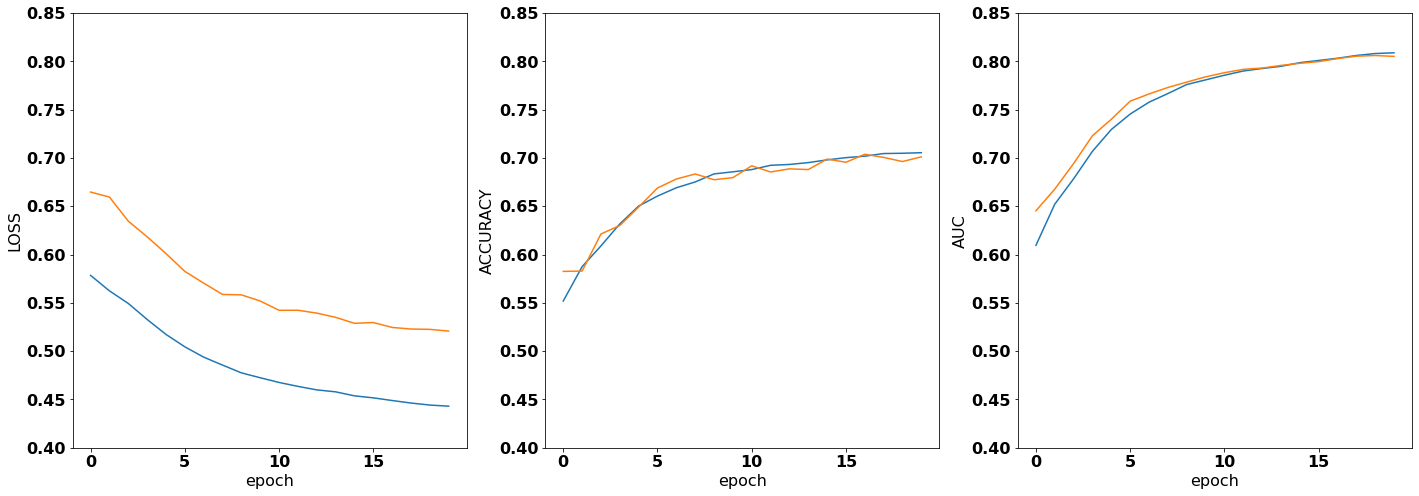

In [31]:
# load plotting modules
import matplotlib
import matplotlib.pyplot as plt

# setting fonts for axes
matplotlib.rcParams['figure.figsize'] = [24, 8] # width and height of figures

font = {'family' : 'DejaVu Sans', # font
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for n, metric in enumerate(metrics_names[0:3]):
    name = metric.replace("_"," ").upper()
    plt.subplot(1,3,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='train')
    plt.plot(history.epoch, history.history['val_'+metric], color=colors[1], linestyle="-", label='valid')
    plt.xlabel('epoch')
    plt.ylabel(name)
    plt.ylim([0.4,0.85])
    if metric == 'recall': plt.legend()